# Assignment: Unsupervised Machine Learning \ Genetic Algorithms

In this assignment you will experience with Genetic Algorithms (GAs), starting from a basic implementation, continuing with dedicated improvements, and later applying it in various unsupervised machine learning scenarios.

---
<font color='blue'>**Comment**: This is the solution of last year students *Kosta Rozen & Guy Fuchs*. In both tasks, the implementation is great. And also it is a good example of how the problem-specific mutation function can be used in the task 2.</font>
---
---

## Part 1: Time Series of 'Likes' Influenced by Personalization

Various personalization algorithms are applied in e-commerce and other kinds of websites/apps in order to increase purchases or user engagement.

The following time series were collected over a period of 20 months from a large online retail store. In this study, during the first 10 months (normalized as the period from month -10 to month 0) a contextual personalization algorithm was applied in order to increase user engagement (measured as the accumulated number of 'Likes' on products shared via Facebook). As in the case with many contextual approaches, this algorithm suffered from the 'filter bubble' problem (https://en.wikipedia.org/wiki/Filter_bubble), and therefore reached a plateau quite quickly.

Nonetheless, this step enabled a more advanced collaborative filtering algorithm to analyze the collected data, learn, and increase user engagement once it was applied in the following 10 months. A classic inflection point was detected after the transition to the new algorithm. A domain expert envisioned the inflection dynamics will behave similarly to the formula f(x) = ax^3 + bx^2 + cx + d. The values of a, b, c and d were found to be 4.8, 12.1, 53.2 and 6219, respectively.

<< Please note: This function is an analytical solution, used here for simplifying the actual study, where a dynamic model was created with ODEs >>

We are given a sample sparse data of users from 10 different European countries. In this project, we will implement a simple GA in order to fit our data to the above-mentioned function, and discover the parameters for a, b, c and d. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read measured data from an Excel file

In [2]:
xlsx = pd.ExcelFile('European Measurements.xlsx')
sheet1 = xlsx.parse(3) # Note the other datasets in the file.
variables = ["Month","Avg. Likes"]
data = sheet1.loc[:, variables].values
print(data)

[[-9.70000000e+00  1.93303385e+03]
 [-9.10000000e+00  3.07678202e+03]
 [-7.70000000e+00  4.61959427e+03]
 [-7.30000000e+00  4.87640388e+03]
 [-7.20000000e+00  5.27621777e+03]
 [-6.20000000e+00  5.76967851e+03]
 [-4.70000000e+00  5.26728526e+03]
 [-4.10000000e+00  6.40777934e+03]
 [-3.30000000e+00  6.05631612e+03]
 [-2.70000000e+00  6.10216500e+03]
 [-2.50000000e+00  5.18359545e+03]
 [-2.30000000e+00  7.03041233e+03]
 [-1.90000000e+00  5.69790109e+03]
 [-1.80000000e+00  5.42920417e+03]
 [-1.20000000e+00  5.23662184e+03]
 [-9.00000000e-01  6.28278124e+03]
 [-1.00000000e-01  6.53285159e+03]
 [ 2.00000000e-01  5.78284515e+03]
 [ 3.00000000e-01  6.57445814e+03]
 [ 4.00000000e-01  5.25761264e+03]
 [ 1.10000000e+00  5.86568880e+03]
 [ 1.50000000e+00  6.92127198e+03]
 [ 1.60000000e+00  6.15982519e+03]
 [ 2.10000000e+00  6.87265063e+03]
 [ 2.20000000e+00  5.57408399e+03]
 [ 2.50000000e+00  5.88485867e+03]
 [ 5.20000000e+00  6.75130936e+03]
 [ 5.40000000e+00  7.32399792e+03]
 [ 5.90000000e+00  7

### Simple GA mechanism

In [9]:
def fitness_function(data, pop):
    fitness = []
    for solution in range(len(pop)):
        error = 0
        for event in range(len(data)):   
            event_time = data[event][0]
            event_measured = data[event][1]
            event_expected = pop[solution][0]*event_time**3 + pop[solution][1]*event_time**2 + pop[solution][2]*event_time + pop[solution][3]
            error +=(event_expected - event_measured)**2
        fitness.append(1/error) # We use 1/error in order to use a maximization mechanism, while we want to minimize the error
    return fitness

def biased_selection(pop, fitness, num_parents):
    sorted_fitness_args = np.argsort(fitness)
    return pop[sorted_fitness_args[-num_parents:],:]
    # parents = np.empty((num_parents, pop.shape[1]))
    # for parent_num in range(num_parents):
    #     max_fitness_idx = np.where(fitness == np.max(fitness))
    #     max_fitness_idx = max_fitness_idx[0][0]
    #     parents[parent_num, :] = pop[max_fitness_idx, :]
    #     fitness[max_fitness_idx] = -99999999999
    # return parents

def recombination(parents, offspring_size):
    offspring = np.empty(offspring_size)
    recombination_point = np.uint8(offspring_size[1]/2)
    for k in range(offspring_size[0]):
        parent1_idx = k%parents.shape[0]
        parent2_idx = (k+1)%parents.shape[0]
        offspring[k, 0:recombination_point] = parents[parent1_idx, 0:recombination_point]
        offspring[k, recombination_point:] = parents[parent2_idx, recombination_point:]
    return offspring

def mutation(offspring_recombination, rate = None, scale = None):
    for idx in range(offspring_recombination.shape[0]):
        random_value = np.random.randint(-100, 100, 1)
        random_index = np.random.randint(0,offspring_recombination.shape[1],1)
        offspring_recombination[idx, random_index] = offspring_recombination[idx, random_index] + random_value
    return offspring_recombination

def stop_criteria(best_outputs, eps):
    return False


### GA application for fitting time series data

In [7]:
def run_ga(formula_degree = 4, number_of_solutions = 500, number_of_parents = 250, number_of_generations = 20, 
           mut_rate = 0.8, mut_scale = 1000, rand_seed = 42):
    
    np.random.seed(rand_seed)
    
    population_size = (number_of_solutions,formula_degree)
    best_outputs = []
    
    # Genesis
    new_population = np.random.randint(low=0, high=10000, size=population_size)
    print("The population of the first generation: ")
    print(new_population)

    # Evolution
    print ("\nEvolution:")
    for generation in range(number_of_generations):

        fitness = fitness_function(data, new_population)
        print(f'Generation = {generation}\tBest fitness = {round(1/np.max(fitness),0):,}')
        # best_outputs.append(np.max(np.sum(new_population*formula_degree, axis=1)))
        best_outputs.append(round(1/np.max(fitness),5))
        parents = biased_selection(new_population, fitness, number_of_parents)
        offspring_recombination = recombination(parents, offspring_size=(population_size[0]-parents.shape[0], formula_degree))
        offspring_mutation = mutation(offspring_recombination, rate = mut_rate, scale = mut_scale)
        new_population[0:parents.shape[0], :] = parents
        new_population[parents.shape[0]:, :] = offspring_mutation
        
        if stop_criteria(best_outputs, 1000):
            break

    # Results
    print("\nThe population of the last generation: ")
    print(new_population)
    fitness = fitness_function(data, new_population)
    best_match_idx = np.where(fitness == np.max(fitness))[0] # this is an array of indices of all best solution(s)
    print("Best solution: ", new_population[best_match_idx[0], :])

    # Chart
    plt.plot(best_outputs)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness Score")
    plt.show()

    return new_population[best_match_idx[0], :], best_outputs[-1]

The population of the first generation: 
[[7270  860 5390 5191]
 [5734 6265  466 4426]
 [5578 8322 1685  769]
 ...
 [5249 5291 2817 9424]
 [3874 9686 4211  661]
 [3374 9208  207 2665]]

Evolution:
Generation = 0	Best fitness = 276,291,782,247.0
Generation = 1	Best fitness = 276,291,782,247.0
Generation = 2	Best fitness = 276,291,782,247.0
Generation = 3	Best fitness = 131,323,911,486.0
Generation = 4	Best fitness = 131,323,911,486.0
Generation = 5	Best fitness = 131,323,911,486.0
Generation = 6	Best fitness = 131,323,911,486.0
Generation = 7	Best fitness = 70,493,354,137.0
Generation = 8	Best fitness = 70,493,354,137.0
Generation = 9	Best fitness = 53,205,759,285.0
Generation = 10	Best fitness = 53,205,759,285.0
Generation = 11	Best fitness = 50,201,337,507.0
Generation = 12	Best fitness = 28,154,600,561.0
Generation = 13	Best fitness = 26,753,781,899.0
Generation = 14	Best fitness = 26,753,781,899.0
Generation = 15	Best fitness = 20,000,639,854.0
Generation = 16	Best fitness = 20,000,

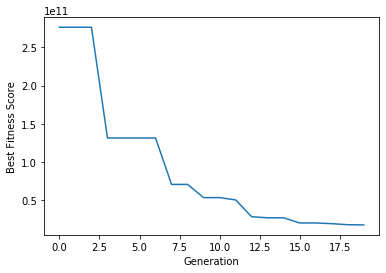

(array([ -21,  505,  751, 7105]), 17458161506.75816)

In [10]:
run_ga()

## Challenge 231
Implement a new and improved GA, based on the one above, by taking the following actions:

1. Make the bias_selection function give more chances to solutions with better fitness values, but not necesseraly take the best ones, as currently done.
2. Make the recombination function make real random recombination along the chromosome and between chromosomes
3. Change the mutation rate and/or scale to better avoid local minima while keeping evolution time short
4. Apply a smarter stopping criterion
5. Consider different GA parameters in order to reach better results

In [11]:
# Your code here
def fitness_function(data, pop):
    fitness = []
    for solution in range(len(pop)):
        error = 0
        for event in range(len(data)):
            event_time = data[event][0]
            event_measured = data[event][1]
            event_expected = pop[solution][0]*event_time**3 + pop[solution][1]*event_time**2 + pop[solution][2]*event_time + pop[solution][3]
            error +=(event_expected - event_measured)**2
        fitness.append(1/error) # We use 1/error in order to use a maximization mechanism, while we want to minimize the error
    return np.array(fitness)

def biased_selection(pop, fitness, num_parents):
    #sorted_fitness_args = np.argsort(fitness)
    #return pop[sorted_fitness_args[-num_parents:],:]
    
    parent_proba = fitness / fitness.sum()
    
    parents_ids = np.random.choice(range(pop.shape[0]), num_parents, replace=True, p = parent_proba)
    
    return pop[parents_ids]

    # parents = np.empty((num_parents, pop.shape[1]))
    # for parent_num in range(num_parents):
    #     max_fitness_idx = np.where(fitness == np.max(fitness))
    #     max_fitness_idx = max_fitness_idx[0][0]
    #     parents[parent_num, :] = pop[max_fitness_idx, :]
    #     fitness[max_fitness_idx] = -99999999999
    # return parents

def recombination(parents, offspring_size):
    offspring = np.empty(offspring_size)
    
    for k in range(offspring_size[0]):
        offspring_parents = np.random.choice(range(parents.shape[0]), 2, replace = False)
        recombination_point = np.random.randint(offspring_size[1])       
        offspring[k, 0:recombination_point] = parents[offspring_parents[0], 0:recombination_point]
        offspring[k, recombination_point:] = parents[offspring_parents[1], recombination_point:]
    return offspring

def mutation(offspring_recombination, rate = 0.5, scale = 100):
    for idx in range(offspring_recombination.shape[0]):
        if (np.random.uniform() < rate):
            random_value = np.random.randint(-scale, scale, 1)
            random_index = np.random.randint(0,offspring_recombination.shape[1],1)
            offspring_recombination[idx, random_index] = offspring_recombination[idx, random_index] + random_value
    return offspring_recombination

def stop_criteria(best_outputs, eps):
    if len(best_outputs) < 2:
        return False
    
    return np.abs(best_outputs[-2] - best_outputs[-1]) <= eps
    

We checked various combinations of values for the model's hyper-parameters:
* number_of_solutions = 500, 1000
* number_of_parents = 25, 50, 75, 100, 200, 250, 300, 400
* number_of_generations = 20, 10 
* mut_rate = 0.5, 0.8, 1
* mut_scale = 200, 1000, 100, 10

The best result was reached with the parameters listed below.
number_of_solutions = 500, number_of_parents = 100, number_of_generations = 50, mut_rate = 1, mut_scale = 300 => 12.5M

The population of the first generation: 
[[7270  860 5390 5191]
 [5734 6265  466 4426]
 [5578 8322 1685  769]
 ...
 [5249 5291 2817 9424]
 [3874 9686 4211  661]
 [3374 9208  207 2665]]

Evolution:
Generation = 0	Best fitness = 276,291,782,247.0
Generation = 1	Best fitness = 47,917,754,258.0
Generation = 2	Best fitness = 19,912,618,772.0
Generation = 3	Best fitness = 6,162,640,134.0
Generation = 4	Best fitness = 2,181,079,354.0
Generation = 5	Best fitness = 836,185,243.0
Generation = 6	Best fitness = 462,979,332.0
Generation = 7	Best fitness = 275,094,230.0
Generation = 8	Best fitness = 214,659,269.0
Generation = 9	Best fitness = 193,095,523.0
Generation = 10	Best fitness = 167,180,365.0
Generation = 11	Best fitness = 114,986,814.0
Generation = 12	Best fitness = 98,280,629.0
Generation = 13	Best fitness = 95,208,998.0
Generation = 14	Best fitness = 88,270,754.0
Generation = 15	Best fitness = 72,205,838.0
Generation = 16	Best fitness = 71,897,853.0
Generation = 17	Best fitness = 67,598,3

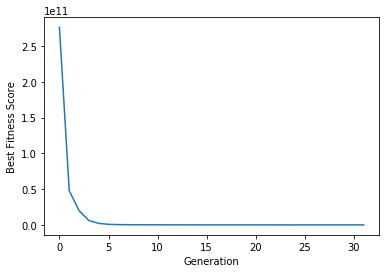

array([   6,   10,  -62, 6256])

In [12]:
best_solution, _ = run_ga(number_of_solutions = 500, number_of_parents = 100, number_of_generations = 50, mut_rate = 1, mut_scale = 300)
best_solution

In [13]:
def polinomial(coeff, x):
    y = np.zeros(x.shape[0]) + coeff[-1]
    rank = len(coeff)
    for n in range(1,rank):           
        y += coeff[-n-1] * x ** n
        
    return y

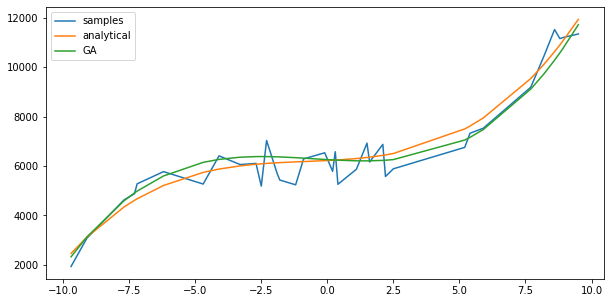

In [14]:
plt.figure(figsize = (10, 5))
x = data[:,0]
plt.plot(x, data[:, 1])
plt.plot(x, polinomial([4.8, 12.1, 53.2, 6219], x))
plt.plot(x, polinomial(best_solution, x))
plt.legend(['samples', 'analytical', 'GA']);

## Part 2: Solving Different Problems With the Same GA

Below is a reminder of the K-Means algorithm you implemented in Assignment 21X.

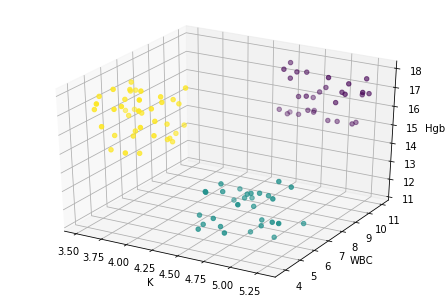

In [91]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

xlsx = pd.ExcelFile('EMR-Blood.xlsx')
sheet1 = xlsx.parse(0)
sheet1.set_index("Key", inplace=True)

variables1 = ["K","WBC","Hgb"]
EMR3d1 = sheet1.loc[:, variables1].values

y_pred_KMeans1 = KMeans(n_clusters=3).fit_predict(EMR3d1)

def make_chart (chart_data, y_pred, labels):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c=y_pred);

make_chart(EMR3d1, y_pred_KMeans1, variables1)

### Challenge 232
Solve the same clustering problem with a GA **without assuming K** (no iteration over differnet Ks), by trying to minimize the intra-cluster distances and maximize the inter-cluster distances.

**hint: You can build the population as the cluster assignment of each point or as cluster centers (consider coordinates boundaries)

In [357]:
# Your code here
class GAClustering():
    
    def __init__(self, initial_clusters_num = 0, number_of_solutions = 500, number_of_parents = 250, number_of_generations = 20, 
               min_generations = 2, gene_mut_rate = 0.1, mut_scale = 1, mut_cluster_num_rate = 0.01, stopping_threshold = 0, rand_seed = 42, verbose = False):
        
        self.initial_clusters_num = initial_clusters_num
        self.number_of_solutions = number_of_solutions
        self.number_of_parents = number_of_parents
        self.number_of_generations = number_of_generations
        self.min_generations = min_generations
        self.gene_mut_rate = gene_mut_rate
        self.mut_scale = mut_scale 
        self.mut_cluster_num_rate = mut_cluster_num_rate
        self.stopping_threshold = stopping_threshold
        self.offsprings_to_generate = number_of_solutions - number_of_parents
        self.verbose = verbose
        np.random.seed(rand_seed)
    
    def genesis(self, k, size):
        # size is a tuple with the full diminsions of the population
        # In This genesis version we are generating diversified initial population with different number
        # of clusters count, from 2 to k.
        creatures_ranges = np.random.randint(low = 2, high = k+1,  size = size[0]).reshape((-1, 1))
        new_population = np.random.randint(low=0, high=creatures_ranges, size=size)
        return new_population
    
    def genesis1(self, k, size): # back of the original simple genesis
        # size is a tuple with the full diminsions of the population
        new_population = np.random.randint(low=0, high=k, size=size)
        return new_population
    
    def fitness_function(self, data, pop):
        fitness = []
        n = data.shape[0]
        dims = data.shape[1]
        data_mean = data.mean(axis = 0)
        best_fitness = 0
        best_WCSS = 0
        best_BCSS = 0
        best_i = 0
        for i, solution in enumerate(pop):          
            error = 0
            clusters = set(solution)
            k = len(clusters)
            WCSS = 0.0
            BCSS = 0.0
            centroids = []
            # calculate BCSS and WCSS
            #print(f'Solution {i} k {k}')
            for cluster in clusters:
                mask = solution == cluster
                cluster_data = data[mask]
                
                centroid = cluster_data.mean(axis = 0)
                BCSS += mask.sum() * ((centroid - data_mean)** 2).sum()
                
                WCSS += ((cluster_data - centroid) ** 2).sum()
                #print(f'BCSS {BCSS}\tWCSS {WCSS}')
            # We use Calinski-Harabasz index as fitness function (high is good)
            
            if (WCSS == 0):
                WCSS = np.finfo(float).eps

            if (k > 1):
                CH_fitness = BCSS/WCSS * (n - k) / (k - 1)
            else:
                CH_fitness = 0
              
            if self.verbose:
                print(f'{i} K={k}\tBCSS {BCSS}\tWCSS {WCSS} => CH fitness {CH_fitness}')
            fitness.append(CH_fitness)
            
        return np.array(fitness)

    def biased_selection(self, pop, fitness, num_parents):
        parent_proba = fitness / fitness.sum()

        parents_ids = np.random.choice(range(pop.shape[0]), num_parents, replace=True, p = parent_proba)

        return pop[parents_ids]

    def recombination(self, parents, offspring_size):
        offspring = np.empty(offspring_size)
        
        for offspring_num in range(offspring_size[0]):
            offspring_parents = np.random.choice(range(parents.shape[0]), 2, replace = False)
            recombination_point = np.random.randint(offspring_size[1])       
            offspring[offspring_num, 0:recombination_point] = parents[offspring_parents[0], 0:recombination_point]
            offspring[offspring_num, recombination_point:] = parents[offspring_parents[1], recombination_point:]
        return offspring

    def mutation(self, offspring_recombination):
        
        gene_mut = int(self.gene_mut_rate * offspring_recombination.shape[1])
        
        allowed_gene_range = self.initial_clusters_num
        
        for idx in range(offspring_recombination.shape[0]):
            offspring = offspring_recombination[idx]
            if np.random.uniform() < self.mut_cluster_num_rate:
                # In this kind of mutation we will randomly pick 2 clusters and unite them
                clusters = list(set(offspring))
                k = len(clusters)
                if k > 2:
                    rand_clusters = np.random.choice(clusters, 2, replace = False)
                    min_cluster = np.min(rand_clusters)
                    max_cluster = np.max(rand_clusters)
                    offspring[offspring==max_cluster] = min_cluster
                    #print(f'{idx} merge cluster {max_cluster} into {min_cluster}')
            if np.random.uniform() < self.mut_cluster_num_rate / 5:
                # Split 1 cluster into two distinct clusters
                clusters = set(offspring)
                new_cluster = min(set(range(len(clusters)+1)) - clusters)
                cluster_to_split = np.random.choice(list(clusters), 1)
                new_cluster_mask = (offspring == cluster_to_split) * (np.random.uniform(offspring_recombination.shape[1]) < 0.5)
                offspring[new_cluster_mask] = new_cluster
                #print(f'{idx} split cluster {cluster_to_split} into {new_cluster}')
                
            else:
                #allowed_gene_range = np.max(offspring_recombination[idx])
                mutation_values = np.random.randint(-self.mut_scale, self.mut_scale+1, gene_mut)
                mutation_indices = np.random.randint(0,offspring_recombination.shape[1],gene_mut)
                #print(f'{idx} Mutations: {mutation_values} at {mutation_indices}')
                offspring_recombination[idx, mutation_indices] = \
                    (offspring_recombination[idx, mutation_indices] + mutation_values) % allowed_gene_range
                
            if self.verbose:
                print(f'{idx} Resulting gene: {offspring}')
        return offspring_recombination

    def stop_criteria(self, best_outputs):
        if len(best_outputs) < self.min_generations:
            return False
        last_solutions = best_outputs[-self.min_generations:]
        return max(last_solutions) - min(last_solutions) <= self.stopping_threshold

    def get_generation_stat(self, new_population, best_match_idx):
        clusters_dist = (np.ceil(np.bincount(new_population.ravel()) * 100 / new_population.size)) / 100
        best_clusters_count = len(set(new_population[best_match_idx, :]))
        
        counters = np.zeros(self.initial_clusters_num + 1)
        
        for idx in range(new_population.shape[0]):
            l = len(set(new_population[idx, :]))
            counters[l] += 1
        
        return best_clusters_count, clusters_dist, counters
    
    def run_ga(self, data):

        genes_count = data.shape[0]
        reset_initial_clusters_num = self.initial_clusters_num == 0
        if reset_initial_clusters_num:
            self.initial_clusters_num = int(np.log2(genes_count)) # We start with log base 2 of number of samples
            
        population_size = (self.number_of_solutions,genes_count)
        generated_offspring_size = (self.offsprings_to_generate, genes_count)
        best_outputs = []

        # Genesis
        new_population = self.genesis(self.initial_clusters_num, population_size)
        print("The population of the first generation: ")
        print(new_population)

        # Evolution
        print ("\nEvolution:")
        for generation in range(self.number_of_generations):

            fitness = self.fitness_function(data, new_population)
            best_fitness = np.max(fitness)
            best_match_idx = np.where(fitness == np.max(fitness))[0]
            #print(new_population.shape)
            best_clusters_count, clusters_dist, clusters_amounts = self.get_generation_stat(new_population, best_match_idx[0])
            print(f'Gen {generation}\tBest {best_fitness:.3f},{best_clusters_count}\tClusters dist {clusters_dist}\tclusters count {clusters_amounts[1:]}')
            
            if self.verbose:
                # Plot best fitted in this generation
                best_match_idx = np.where(fitness == np.max(fitness))[0]
                make_chart(EMR3d1, new_population[best_match_idx[0], :], variables1)
            
            # best_outputs.append(np.max(np.sum(new_population*formula_degree, axis=1)))
            best_outputs.append(best_fitness)
            parents = self.biased_selection(new_population, fitness, self.number_of_parents)
            if self.verbose:
                print(f'Parents({self.number_of_parents}):\n{parents}')
            offspring_recombination = self.recombination(parents, offspring_size=generated_offspring_size)
            offspring_mutation = self.mutation(offspring_recombination)
            new_population[0:self.number_of_parents, :] = parents
            new_population[self.number_of_parents:, :] = offspring_mutation

            
            if self.stop_criteria(best_outputs):
                break

        # Results
        print("\nThe population of the last generation: ")
        print(new_population)
        fitness = self.fitness_function(data, new_population)
        best_match_idx = np.where(fitness == np.max(fitness))[0] # this is an array of indices of all best solution(s)
        print("Best solution: ", new_population[best_match_idx[0], :])

        # Chart
        plt.plot(best_outputs)
        plt.xlabel("Generation")
        plt.ylabel("Best Fitness Score")
        plt.show()

        if reset_initial_clusters_num:
            self.initial_clusters_num = 0
        
        return new_population[best_match_idx[0], :], best_outputs[-1]

In [359]:
test = GAClustering(number_of_solutions = 750, number_of_parents = 450, 
                      number_of_generations = 10000, min_generations = 50, 
                      gene_mut_rate = 0.03, mut_scale = 1, mut_cluster_num_rate = 0.02, stopping_threshold = 0, rand_seed = 42)

The population of the first generation: 
[[3 3 0 ... 2 0 2]
 [2 4 3 ... 5 3 0]
 [0 1 0 ... 3 2 1]
 ...
 [1 1 3 ... 2 0 1]
 [0 1 0 ... 0 0 1]
 [2 0 3 ... 0 2 3]]

Evolution:
Gen 0	Best 7.185,2	Clusters dist [0.3  0.3  0.19 0.13 0.08 0.04]	clusters count [  0. 160. 142. 136. 159. 153.]
Gen 1	Best 7.185,2	Clusters dist [0.29 0.3  0.18 0.14 0.08 0.04]	clusters count [  0.  96. 100. 144. 206. 204.]
Gen 2	Best 7.185,2	Clusters dist [0.3  0.32 0.17 0.12 0.08 0.03]	clusters count [  0.  84.  98. 120. 251. 197.]
Gen 3	Best 7.607,3	Clusters dist [0.32 0.36 0.17 0.1  0.06 0.02]	clusters count [  0.  79. 142. 132. 242. 155.]
Gen 4	Best 7.607,3	Clusters dist [0.34 0.38 0.17 0.08 0.04 0.01]	clusters count [  0.  82. 149. 172. 205. 142.]
Gen 5	Best 7.607,3	Clusters dist [0.36 0.41 0.17 0.05 0.03 0.01]	clusters count [  0.  75. 213. 202. 152. 108.]
Gen 6	Best 7.799,3	Clusters dist [0.36 0.42 0.18 0.03 0.02 0.01]	clusters count [  0.  63. 265. 203. 138.  81.]
Gen 7	Best 7.928,3	Clusters dist [0.36 0.43

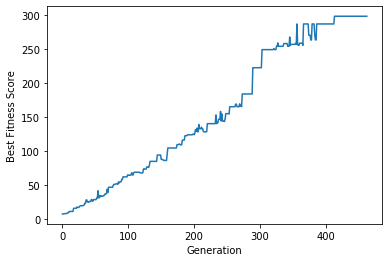

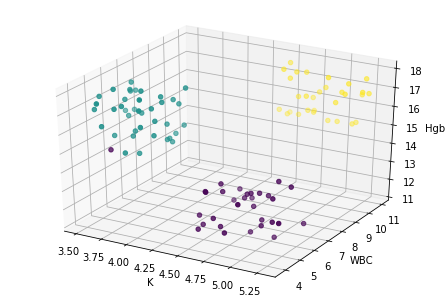

In [356]:
results, score = test1.run_ga(EMR3d1)
make_chart(EMR3d1, results, variables)

## Challenge 233: Reconstruct Image (Bonus)
In this part you will attemp to generate an image which is closest to a target image given. 

First we will load the image from a file:


In [ ]:
import matplotlib.image as mpimg

img=mpimg.imread('pexels-photo-57905.jpeg')

For simplicity (and running time), we focus on a small part of the image:

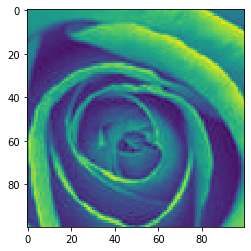

In [64]:
import matplotlib.pyplot as plt
imgplot = plt.imshow(img[100:200,200:300,0])

And we will define this part as out target image to reconstruct:

In [ ]:
target = img[100:200,200:300,0]

Your mission is to generate an image starting at random noise. The goal is to get an image as close as possible to the target. Don;t worry if it's still noisy...
FYI: GA are not the best solution for these types of problems ;)
You can use these blog posts to give you ideas:
https://towardsdatascience.com/genetic-algorithm-implementation-in-python-5ab67bb124a6

https://heartbeat.fritz.ai/reproducing-images-using-a-genetic-algorithm-with-python-91fc701ff84

In [ ]:
# Your code here